# CSV 파일 읽고 쓰기

csv는 Comma Seperated Values의 약자로, 말 그대로 콤마(,)로 구분된 데이터들을 말합니다. [위키피디아](https://en.wikipedia.org/wiki/Comma-separated_values)에서 예제를 확인할 수 있습니다. 엄청 심플한 버젼의 엑셀 포맷이라고 보셔도 무방합니다! 실제로 *.csv 파일은 엑셀(윈도우)이나 넘버스(맥)으로 열 수 있습니다.

In [1]:
# csv 파일로 바꿔봅시다. 
import csv

# https://docs.python.org/2/library/csv.html#csv.reader
# delimiter, qoutechar, qouting 옵션이 뭔지 직접 해봅시다.
with open('sample.csv', 'w') as csvfile:
    # default delimiter는 , quotechar는 "입니다.
    writer = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    
    writer.writerow(['검사외전', '범죄', '126분'])
    # 아래와 같이 제목에 콤마(,)가 들어가면 delimiter인 콤마(,)와 헷갈리게 됩니다.
    # 그래서 quotechar(|)로 제목을 감싸주게 됩니다.
    # 직접 확인해보죠.
    writer.writerow(['쿵푸팬더3 (Kung Fu Panda 3, 2016)', '애니메이션', '95분'])

In [2]:
# csv 파일을 읽어옵니다.
data = []
with open('sample.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row in reader:
        data.append(row)
        
print data

[['\xea\xb2\x80\xec\x82\xac\xec\x99\xb8\xec\xa0\x84', '\xeb\xb2\x94\xec\xa3\x84', '126\xeb\xb6\x84'], ['\xec\xbf\xb5\xed\x91\xb8\xed\x8c\xac\xeb\x8d\x943 (Kung Fu Panda 3, 2016)', '\xec\x95\xa0\xeb\x8b\x88\xeb\xa9\x94\xec\x9d\xb4\xec\x85\x98', '95\xeb\xb6\x84']]


## 해보기

이번에는 delimiter를 세미콜론(';')으로 하고, quotechar는 '/'로 해봅시다. 여러줄을 한 번에 쓸때는 `writer.writerows` 하면 됩니다.

In [40]:
data = [['검;사;외;전', '범죄', '126분'], \
        ['쿵;푸;팬;더;3 (Kung Fu Panda 3, 2016)', \
         '애;니;메;이;션', '95분']]

def write_csv(data, filename, delimiter=',', quotechar='"'):
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, \
                            delimiter=delimiter,\
                            quotechar=quotechar)

        writer.writerows(data)

    return filename

In [41]:
write_csv(data,'movies_sample.csv')

'movies_sample.csv'

## 해보기

In [15]:
def read_csv(filename, delimiter=',', quotechar='"'):
    data = []

    with open(filename, 'r') as csvfile:
        reader = csv.reader(csvfile, \
                            delimiter=delimiter,\
                            quotechar=quotechar)

        for row in reader:
            data.append(row)

    return data

In [16]:
data = read_csv('movies_sample.csv')

In [17]:
for row in data:
    for item in row:
        print item

검;사;외;전
범죄
126분
쿵;푸;팬;더;3 (Kung Fu Panda 3, 2016)
애;니;메;이;션
95분


# 지난주에 배운 movie_total을 csv로 저장해봅시다.

In [42]:
#-*- coding: utf-8 -*-

import csv
from bs4 import BeautifulSoup as bs
import requests

def movie_crawler(url):
    res = requests.get(url)

    table = []

    if res.status_code == 200:
        soup = bs(res.text)

        movies = soup.findAll('div', {'itemtype': 'http://schema.org/Movie'})

        print len(movies)

        for movie in movies:
            row = []

            title = movie.findAll('h4', {'itemprop': 'name'})
            score = movie.select('div.rating_txt > div > strong')
            genres = movie.findAll('span', {'itemprop': 'genre'})
            running_time = movie.findAll('time', {'itemprop': 'duration'})
            actors = movie.findAll('span', {'itemprop': 'actors'})

            title =  title[0].text.strip() if len(title)>0 else ""
            score = score[0].text.strip() if len(score)>0 else ""
            genre = "/".join([genre.text.strip() for genre in genres])
            running_time = running_time[0].text.strip() if len(running_time)>0 else ""
            actor = "/".join([actor.text.strip() for actor in actors])

            row = [title, score, genre, running_time, actor]
            table.append(row)

    return table


data = movie_crawler('http://www.imdb.com/movies-coming-soon/2015-01')

32


'movie_info.csv'

In [43]:
# 그러면 이제 2015-01부터 2015-12까지 영화정보를 긁어봅시다.
target_url = 'http://www.imdb.com/movies-coming-soon/{0}'
movie_total = []
for i in range(1,13):
    # string.zfill(2)을 사용해보세요. zero padding이 생깁니다.
    date = "2015-" + str(i).zfill(2)
    print target_url.format(date) + " crawling.."
    movie_total += movie_crawler(target_url.format(date))

http://www.imdb.com/movies-coming-soon/2015-01 crawling..
32
http://www.imdb.com/movies-coming-soon/2015-02 crawling..
23
http://www.imdb.com/movies-coming-soon/2015-03 crawling..
27
http://www.imdb.com/movies-coming-soon/2015-04 crawling..
29
http://www.imdb.com/movies-coming-soon/2015-05 crawling..
39
http://www.imdb.com/movies-coming-soon/2015-06 crawling..
31
http://www.imdb.com/movies-coming-soon/2015-07 crawling..
38
http://www.imdb.com/movies-coming-soon/2015-08 crawling..
32
http://www.imdb.com/movies-coming-soon/2015-09 crawling..
32
http://www.imdb.com/movies-coming-soon/2015-10 crawling..
43
http://www.imdb.com/movies-coming-soon/2015-11 crawling..
30
http://www.imdb.com/movies-coming-soon/2015-12 crawling..
33


In [45]:
def write_csv(data, filename, delimiter=",", quotechar='"'):
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile, \
                            delimiter=delimiter,\
                            quotechar=quotechar)

        writer.writerows([[item.encode('utf-8') for item in row] for row in data])

        # [[item.encode('utf-8') for item in row] for row in data]

    return filename

In [44]:
write_csv(movie_total, "movie_info.csv")

'movie_info.csv'

In [48]:
# 자, 이제 파이썬 데이터 분석툴 pandas 소개합니다.
from pandas import DataFrame

In [50]:
movie_df = DataFrame(movie_total, \
                     columns=['title', 'scorr', 'genre', 'running time', 'actors'])

In [51]:
len(movie_df)

389

In [52]:
# csv format으로 저장하기 (encoding utf-8)
movie_df.to_csv('./movie_from_df.csv', encoding='utf-8', index=False) #, header=False)

In [53]:
import pandas as pd
movie_df = pd.read_csv('./movie_from_df.csv')
movie_df.head()

,title,scorr,genre,running time,actors
0,The Woman in Black 2: Angel of Death (2014),42,Drama/Horror/Thriller,98 min,Helen McCrory/Jeremy Irvine/Phoebe Fox/Leanne ...
1,A Most Violent Year (2014),79,Action/Crime/Drama/Thriller,125 min,Oscar Isaac/Jessica Chastain/David Oyelowo/Ale...
2,Leviafan (2014),92,Drama,140 min,Aleksey Serebryakov/Elena Lyadova/Roman Madyan...
3,[REC] 4: Apocalipsis (2014),53,Action/Horror/Thriller,95 min,Manuela Velasco/Paco Manzanedo/Héctor Colomé/I...
4,The Search for General Tso (2014),72,Documentary/Comedy/History/Mystery,71 min,Ian Cheney


# iPython notebook 설치하기

[iPython 설치 가이드](./ipython_notebook.pdf)

iPython notebook은 현재 보고 있는 이 웹 인터페이스를 지원하고, numpy와 pandas는 파이썬 데이터 분석에 가장 많이 활용되는 패키지입니다. 앞으로 데이터를 다루고 분석하는데 Pandas를 주로 사용하겠지만, Pandas는 numpy 자료구조에 dependency가 있습니다. numpy는 수치 연산에 강력한 ndarray 자료구조와 각종 메소드들을 지원합니다.

# Pandas.DataFrame > Pandas.Series > numpy.ndarray

1. Pandas.DataFrame은 2차원 Data type. '테이블'을 생각하시면 편합니다.
2. Pandas.Series는 index가 있는 1차원 Data type. 테이블에서 '하나의 column' 혹은 '하나의 row'를 생각하시면 편합니다.
3. numpy.ndarray는 파이썬 기본 자료구조인 list보다 훨씬 파워풀한 1차원 Array.

In [25]:
# 일단은 Numpy, Series, DataFrame 관계부터 배워봅시다.
import pandas
import numpy

In [35]:
# Pandas DataFrame 입니다.
pd_df = pandas.DataFrame([[1,2,3],[3,4,5]], columns=['a','b','c'])
pd_df

,a,b,c
0,1,2,3
1,3,4,5


In [158]:
# Pandas Series 입니다.
pd_sr = pandas.Series([1,2,3])
pd_sr

0    1
1    2
2    3
dtype: int64

In [159]:
# Numpy array 입니다. 
# 중요: numpy.array 메소드로 numpy.ndarray 객체를 생성합니다.
np_ar = numpy.array([1,2,'3'])
np_ar

array(['1', '2', '3'], 
      dtype='|S21')

In [155]:
# Series의 value 값이 Numpy array와 같네요.
pd_sr.values

array([1, 2, 3])

In [157]:
str_list = [1,2,3,'2']
str_list

[1, 2, 3, '2']

In [40]:
# DataFrame 첫번째 row는 Series와 같네요.
pd_df.ix[0]

a    1
b    2
c    3
Name: 0, dtype: int64

In [41]:
# DataFrame column도 Series입니다.
pd_df['a']

0    1
1    3
Name: a, dtype: int64

In [32]:
# 그 value 값들이 Numpy array와 같네요.
pd_df.ix[0].values

array([1, 2, 3])

# Pandas DataFrame Basic

In [160]:
import numpy as np
import pandas as pd
from pandas import Series, DataFrame

In [179]:
data = {
    'name': ['똘기', '떵이', '호치', '새촘'],
    'chinese zodiac': ['Rat', 'Pig', 'Tiger', 'Rabbit'],
    'year': [1984,1985,1986,1987]
}

data = [
    ['a','b'],
    ['a','b']
]

In [180]:
# DataFrame은 Pandas에 구현되어 있는 기본 자료구조로, 
# 2차원(row, column) 데이터를 표현할 수 있습니다.

# key가 column명, value 하나 하나가 row에 들어갑니다.
data = {
    'name': ['똘기', '떵이', '호치', '새촘'],
    'chinese zodiac': ['Rat', 'Pig', 'Tiger', 'Rabbit'],
    'year': [1984,1985,1986,1987]
}

df = DataFrame(data)
df

,chinese zodiac,name,year
0,Rat,똘기,1984
1,Pig,떵이,1985
2,Tiger,호치,1986
3,Rabbit,새촘,1987


In [181]:
# column 순서 바꾸기
df = DataFrame(data, columns=['name', 'year', 'chinese zodiac'])
df

,name,year,chinese zodiac
0,똘기,1984,Rat
1,떵이,1985,Pig
2,호치,1986,Tiger
3,새촘,1987,Rabbit


In [182]:
# column 추가하기
df['한국 띠'] = ['쥐띠','돼지띠','호랑이띠','토끼띠']

In [183]:
df

,name,year,chinese zodiac,한국 띠
0,똘기,1984,Rat,쥐띠
1,떵이,1985,Pig,돼지띠
2,호치,1986,Tiger,호랑이띠
3,새촘,1987,Rabbit,토끼띠


In [184]:
len([1,2,3])

3

In [185]:
len(df)

4

In [187]:
# row 추가하기
df.loc[10] = ['드라곤', 1988, 'Dragon', '용띠']

In [188]:
df

,name,year,chinese zodiac,한국 띠
0,똘기,1984,Rat,쥐띠
1,떵이,1985,Pig,돼지띠
2,호치,1986,Tiger,호랑이띠
3,새촘,1987,Rabbit,토끼띠
4,드라곤,1988,Dragon,용띠
10,드라곤,1988,Dragon,용띠


In [173]:
# index(row 명)도 따로 정해줄 수 있습니다.
df = DataFrame(data, \
               columns=['name', 'year', 'chinese zodiac'], \
               index=['a',2,3,4])
df

,name,year,chinese zodiac
a,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [189]:
# df.ix['a']
df['name']

0      똘기
1      떵이
2      호치
3      새촘
4     드라곤
10    드라곤
Name: name, dtype: object

In [116]:
# column명을 바꾸기 위해서는 
df.columns = ['이름', '년도', '띠']
df

,이름,년도,띠
1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [117]:
# column을 선택하려면 아래와 같이 합니다.
df['이름']

1    똘기
2    떵이
3    호치
4    새촘
Name: 이름, dtype: object

In [119]:
## 여러개의 column은 이렇게 선택합니다.
df[['이름','년도']]

,이름,년도
1,똘기,1984
2,떵이,1985
3,호치,1986
4,새촘,1987


In [53]:
# Series type 입니다. Series의 정체는 뭘까요?
type(df['이름'])

pandas.core.series.Series

In [54]:
# row를 선택하려면 ix 메소드를 통해서 고릅니다. 
# 주의: df.ix[0]은 0이 index로 지정되어있지 않기 때문에 에러가 납니다! 
df.ix[1]

이름      똘기
년도    1984
띠      Rat
Name: 1, dtype: object

In [55]:
# 이 녀석도 Series type 입니다.
type(df.ix[1])

pandas.core.series.Series

In [56]:
# column을 확인합니다.
df.columns

Index([u'이름', u'년도', u'띠'], dtype='object')

In [57]:
# index를 확인합니다. data type이 integer네요.
df.index

Int64Index([1, 2, 3, 4], dtype='int64')

In [58]:
df.index.dtype

dtype('int64')

In [59]:
type(df.index.dtype)

numpy.dtype

In [194]:
# 컬럼명 지정해서 바꾸려면 rename을 합니다.
df.rename(columns = {'name': '이름'}, index = {1:'12-1'}, inplace=True)

In [195]:
# 실제로는 바뀌지 않았습니다. 바꿔주려면 inplace=True 옵션을 줍니다.
df

,이름,year,chinese zodiac,한국 띠
0,똘기,1984,Rat,쥐띠
12-1,떵이,1985,Pig,돼지띠
2,호치,1986,Tiger,호랑이띠
3,새촘,1987,Rabbit,토끼띠
4,드라곤,1988,Dragon,용띠
10,드라곤,1988,Dragon,용띠


In [62]:
# index도 아직 integer 타입이죠?
df.index

Int64Index([1, 2, 3, 4], dtype='int64')

In [63]:
# 컬럼명 지정해서 바꾸려면 rename을 합니다.
df.rename(columns = {'년도': '출생년도'}, index = {1:'12-1'}, inplace=True)

In [64]:
df

,이름,출생년도,띠
12-1,똘기,1984,Rat
2,떵이,1985,Pig
3,호치,1986,Tiger
4,새촘,1987,Rabbit


In [65]:
# type이 int64에서 object로 바뀌었네요
df.index

Index([u'12-1', 2, 3, 4], dtype='object')

In [66]:
df.index.dtype

dtype('O')

In [67]:
# row를 선택하려면 ix 메소드를 통해서 고릅니다. 
df.ix['12-1']

이름        똘기
출생년도    1984
띠        Rat
Name: 12-1, dtype: object

In [196]:
# index의 type이 object로 바뀌니 index 0에 접근이 가능하네요!
df.ix[0]

이름                  똘기
year              1984
chinese zodiac     Rat
한국 띠                쥐띠
Name: 0, dtype: object

## 해보기


In [214]:
data = [
    ['영화 제목1', 120, '영화 감독1'],
    ['영화 제목2', 150, '영화 감독2'],
    ['영화 제목3', 180, '영화 감독3']
]

# 1. DataFrame에 넣고 column에 [제목, 상영 시간, 감독]이라고 지정해보세요.
# 2. 컬럼 순서 감독->상영 시간->제목으로 바꿔보세요.
# 3. index도 0,1,2가 아니라 1,2,3으로 지정해보세요.

# df = DataFrame(...)
# df

In [235]:
df1 = DataFrame(data, columns=['제목', '상영 시간', '감독'], index=[1,2,3])
df1

,제목,상영 시간,감독
1,영화 제목1,120,영화 감독1
2,영화 제목2,150,영화 감독2
3,영화 제목3,180,영화 감독3


In [232]:
df2 = df1[['감독', '상영 시간', '제목']]

In [234]:
df2

,감독,상영 시간,제목
0,영화 감독1,120,영화 제목1
1,영화 감독2,150,영화 제목2
2,영화 감독3,180,영화 제목3


In [228]:
df1[['감독', '상영 시간', '제목']]

,감독,상영 시간,제목
0,영화 감독1,120,영화 제목1
1,영화 감독2,150,영화 제목2
2,영화 감독3,180,영화 제목3


In [218]:
df1.columns = ['감독', '상영 시간', '제목']

In [220]:
df1

,감독,상영 시간,제목
0,영화 제목1,120,영화 감독1
1,영화 제목2,150,영화 감독2
2,영화 제목3,180,영화 감독3


In [223]:
df1.index = [1,2,3]

In [224]:
df1

,감독,상영 시간,제목
1,영화 제목1,120,영화 감독1
2,영화 제목2,150,영화 감독2
3,영화 제목3,180,영화 감독3


## 해보기

In [236]:
data = {
    '제목': ['영화 제목1', '영화 제목2', '영화 제목3'],
    '상영 시간': [120, 150, 180],
    '감독': ['영화 감독1', '영화 감독2', '영화 감독3']
}

# 1. DataFrame으로 만들고, 컬럼을 제목->상영 시간->감독 순으로 바꿔보세요.
# 2. 컬럼명을 제목->title, 감독->director, 상영 시간->running time으로 바꿔보세요.
# 3. index를 '1관', '2관', '3관'으로 바꿔보세요.
# 4. 1관을 선택해서 출력해보세요.

In [237]:
df2 = DataFrame(data)

In [239]:
df2.columns = ['제목', '상영 시간', '감독']

In [241]:
df2.columns = ['title', 'running time', 'director']

In [243]:
df2.index = ['1관', '2관', '3관']

In [245]:
df2.ix['1관']

title           영화 감독1
running time       120
director        영화 제목1
Name: 1관, dtype: object

# Pandas로 데이터 읽어오기

In [56]:
import pandas

In [246]:
# http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data_MLB_HeightsWeights
# 위 사이트에 들어가서 표를 긁어서 복사(ctrl+c, 맥에서는 cmd+c) 합니다.

# 안되시는 분들은 직접 csv 파일 다운로드해서 pd.read_csv(파일 이름) 해보세요
# https://www.dropbox.com/s/9mgjiu00h3q8n0r/bp_data.csv?dl=1
baseball_players = pandas.read_clipboard()

In [6]:
# DataFrame의 head() 메소드를 활용해 잘 붙었는지 확인해볼까요? 
baseball_players.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [250]:
# 긁어온 데이터를 csv로 저장해봅시다.
baseball_players.to_csv('./baseball_player.csv', index=False)

In [122]:
# 저장한 .csv 데이터를 다시 읽어볼까요? 현재 폴더에 가서 잘 있는지 확인해봅시다.
bp_data = pandas.read_csv('./baseball_player.csv')

In [123]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [124]:
inch_to_cm = 2.54
pound_to_kg = 0.453592

In [125]:
height = bp_data['Height(inches)'].values

In [126]:
height_cm = height * inch_to_cm

In [127]:
# height_cm[height_cm>180]

In [128]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age
0,Adam_Donachie,BAL,Catcher,74,180,22.99
1,Paul_Bako,BAL,Catcher,74,215,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71


In [129]:
bp_data.columns

Index([u'Name', u'Team', u'Position', u'Height(inches)', u'Weight(pounds)',
       u'Age'],
      dtype='object')

In [130]:
# Series
heights = bp_data['Height(inches)']
heights.head()

0    74
1    74
2    72
3    72
4    73
Name: Height(inches), dtype: int64

In [131]:
# numpy ndarray 자료구조로 value들을 리턴합니다.
heights.values

array([74, 74, 72, ..., 75, 75, 73])

In [132]:
# 이렇게 index도 받아올 수 있습니다. 
heights.index

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1024, 1025, 1026, 1027, 1028, 1029, 1030, 1031, 1032, 1033],
           dtype='int64', length=1034)

# Numpy 부터 보고갑시다

일단 numpy에서는 아까 잠시 살펴본 ndarray 자료구조를 잘 익히면 됩니다. 

In [143]:
import numpy as np

# numpy로 array를 만들어봅시다.
np.array([1,2,3,4])

array([1, 2, 3, 4])

In [144]:
type(np.array([1,2,3,4]))

numpy.ndarray

In [145]:
# list와 비슷해보이죠?
[1,2,3,4]

[1, 2, 3, 4]

In [146]:
# list와 numpy ndarray가 뚜렷하게 차이나는 점.

# 1. ndarray는 하나의 type만 넣을 수 있음.(type coercion)
print [1,2,'3']
print np.array([1,2,'3'])
print np.array([1,2,3]).dtype
print np.array([1,2,'3']).dtype
# (numpy에서는 single data type을 사용하기에 속도가 굉장히 빠르다고 합니다.)

# 2. 기본 연산(+,*,-,+)이 다른 의미를 가짐
print [1,2,3]+[4,5,6]
print [1,2,3]*3
print np.array([1,2,3])+np.array([4,5,6])
print np.array([1,2,3])*3

[1, 2, '3']
['1' '2' '3']
int64
|S21
[1, 2, 3, 4, 5, 6]
[1, 2, 3, 1, 2, 3, 1, 2, 3]
[5 7 9]
[3 6 9]


In [147]:
np1 = np.array([1,2,3])
np2 = np.array([2,2,2])

In [148]:
np1*np2

array([2, 4, 6])

In [149]:
np1+np2

array([3, 4, 5])

In [150]:
np1**2

array([1, 4, 9])

In [151]:
np2/2

array([1, 1, 1])

In [152]:
# np_heights에 농구선수들의 키를 ndarray로 가져옵시다.
np_heights = heights.values

In [153]:
np_heights[:5]

array([74, 74, 72, 72, 73])

In [154]:
# 근데 농구선수 키가 왜 이렇게 작은걸까요? 인치를 센티미터로 바꿔봅시다. 
inch_to_cm = 2.54
pound_to_kg = 0.453592

cm_heights = np_heights*inch_to_cm
cm_heights

array([ 187.96,  187.96,  182.88, ...,  190.5 ,  190.5 ,  185.42])

In [155]:
height_cm

array([ 187.96,  187.96,  182.88, ...,  190.5 ,  190.5 ,  185.42])

In [156]:
len(height_cm[height_cm>180])

954

In [157]:
# 전체 농구선수 중에..
len(height_cm)

1034

In [158]:
# 180이상이 몇명이나 있는지 찾아봅시다.
len(height_cm[height_cm>180])

954

In [159]:
def square_array(arr):
    return arr**2

square_array(height_cm)

array([ 35328.9616,  35328.9616,  33445.0944, ...,  36290.25  ,
        36290.25  ,  34380.5764])

In [160]:
inch_to_cm = 2.54
pound_to_kg = 0.453592

height_cm = bp_data['Height(inches)'].values * inch_to_cm
weight_kg = bp_data['Weight(pounds)'].values * pound_to_kg

In [161]:
weight_kg

array([ 81.64656,  97.52228,  95.25432, ...,  92.98636,  86.18248,
        88.45044])

In [162]:
height_cm

array([ 187.96,  187.96,  182.88, ...,  190.5 ,  190.5 ,  185.42])

##  해보기 
야구선수들의 bmi(body mass index)를 구해봅시다. 

$$bmi = weight(kg) / height(m^2)$$

In [163]:
# ndarray자료구조인 weight, height를 받아 bmi를 계산해서 리턴합니다. 
# kg, m^2 단위 조심하세요!
def cal_bmi(weight, height):
    return weight / height**2

height_m = height_cm * 0.01
bmi = cal_bmi(weight_kg, height_m)

## 해보기

1. bmi가 30이상인 비만 야구선수들을 찾아봅시다.
2. 20 미만인 저체중 선수들을 찾아봅시다.

In [164]:
# bmi[bmi>30]
bmi[bmi<20]

array([ 19.4984471])

In [165]:
bp_data['bmi'] = bmi

In [166]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi
0,Adam_Donachie,BAL,Catcher,74,180,22.99,23.110376
1,Paul_Bako,BAL,Catcher,74,215,34.69,27.604061
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78,28.480805
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43,28.480805
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71,24.803335


# Apply

In [173]:
from pandas import Series, DataFrame

# apply는 이런식으로 사용합니다.
def square(x):
    return x*x

Series([1,2,3]).apply(square)

0    1
1    4
2    9
dtype: int64

In [174]:
numbers = Series([1,2,3,4,5,6,7,8])

In [175]:
def get_odd_even(x):
    if x%2==0:
        return 'Even'
    else:
        return 'Odd'

numbers.apply(get_odd_even)

0     Odd
1    Even
2     Odd
3    Even
4     Odd
5    Even
6     Odd
7    Even
dtype: object

In [176]:
# bmi 컬럼을 추가하고, 
bp_data['bmi'] = bmi

In [177]:
# 30초과는 fat, 
# 25초과는 over weight, 
# 20초과는 normal, 
# 그 미만은 low weight로 표기해봅시다.
def set_status(bmi):
    if bmi > 30:
        return 'fat'
    elif bmi > 25:
        return 'over weight'
    elif bmi > 20:
        return 'normal'
    else:
        return 'low weight'
    
status = bp_data['bmi'].apply(set_status)

In [178]:
bp_data['status'] = status

In [179]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status
0,Adam_Donachie,BAL,Catcher,74,180,22.99,23.110376,normal
1,Paul_Bako,BAL,Catcher,74,215,34.69,27.604061,over weight
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78,28.480805,over weight
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43,28.480805,over weight
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71,24.803335,normal


## 해보기

age_status라는 컬럼을 만들고, Age를 기준으로 35 이상은 agegroup_1, 30 이상은 agegroup_2, 25이상은 agegroup_3, 그 이하는 agegroup_4로 저장해봅시다.

In [180]:
def set_age_status(age):
    if age > 35:
        return 'agegroup_1'
    elif age > 30:
        return 'agegroup_2'
    elif age > 25:
        return 'agegroup_3'
    else:
        return 'agegroup_4'

bp_data['age_status'] = bp_data['Age'].apply(set_age_status)

In [181]:
bp_data[(bp_data['status']=='normal') & (bp_data['age_status']=='agegroup_2')].head()

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status
23,Kris_Benson,BAL,Starting_Pitcher,76,195,32.31,23.735882,normal,agegroup_2
24,Scott_Williamson,BAL,Relief_Pitcher,72,180,31.03,24.412118,normal,agegroup_2
27,Chad_Bradford,BAL,Relief_Pitcher,77,203,32.46,24.072020,normal,agegroup_2
97,Justin_Speier,ANA,Relief_Pitcher,76,205,33.31,24.953107,normal,agegroup_2
100,Scot_Shields,ANA,Relief_Pitcher,73,170,31.61,22.428548,normal,agegroup_2


In [182]:
bp_data['Weight(kg)'] = weight_kg
bp_data['Height(cm)'] = height_cm

In [183]:
bp_data.head()

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
0,Adam_Donachie,BAL,Catcher,74,180,22.99,23.110376,normal,agegroup_4,81.646560,187.96
1,Paul_Bako,BAL,Catcher,74,215,34.69,27.604061,over weight,agegroup_2,97.522280,187.96
2,Ramon_Hernandez,BAL,Catcher,72,210,30.78,28.480805,over weight,agegroup_2,95.254320,182.88
3,Kevin_Millar,BAL,First_Baseman,72,210,35.43,28.480805,over weight,agegroup_1,95.254320,182.88
4,Chris_Gomez,BAL,First_Baseman,73,188,35.71,24.803335,normal,agegroup_1,85.275296,185.42


In [184]:
# Position 별로 얼마나 있는지 살펴봅시다.
bp_data['Position'].value_counts()

Relief_Pitcher       315
Starting_Pitcher     221
Outfielder           194
Catcher               76
Second_Baseman        58
First_Baseman         55
Shortstop             52
Third_Baseman         45
Designated_Hitter     18
Name: Position, dtype: int64

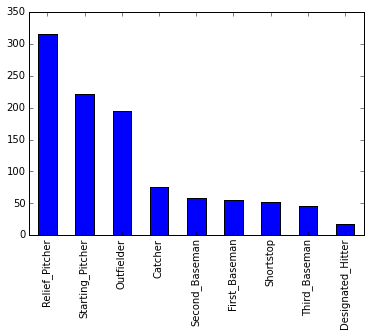

In [185]:
# Numeric data to plot.
# import matplotlib as plt <= for PyCharm
%matplotlib inline 
bp_data['Position'].value_counts().plot(kind='bar')
# plt.pyplot.show() <= for PyCharm


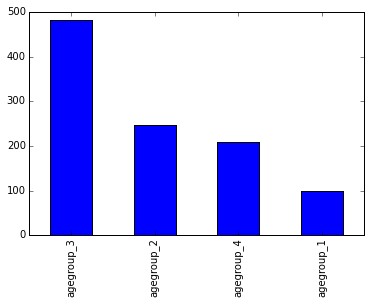

In [186]:
bp_data['age_status'].value_counts().plot(kind='bar')

In [187]:
bp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 0 to 1033
Data columns (total 11 columns):
Name              1034 non-null object
Team              1034 non-null object
Position          1034 non-null object
Height(inches)    1034 non-null int64
Weight(pounds)    1033 non-null float64
Age               1034 non-null float64
bmi               1033 non-null float64
status            1034 non-null object
age_status        1034 non-null object
Weight(kg)        1033 non-null float64
Height(cm)        1034 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 96.9+ KB


In [188]:
bp_data.describe()

,Height(inches),Weight(pounds),Age,bmi,Weight(kg),Height(cm)
count,1034.000000,1033.000000,1034.000000,1033.000000,1033.000000,1034.000000
mean,73.697292,201.689255,28.736712,26.093497,91.484632,187.191122
std,2.305818,20.991491,4.320310,2.300437,9.521572,5.856779
min,67.000000,150.000000,20.900000,19.498447,68.038800,170.180000
25%,72.000000,187.000000,25.440000,24.407276,84.821704,182.880000
50%,74.000000,200.000000,27.925000,26.087904,90.718400,187.960000
75%,75.000000,215.000000,31.232500,27.604061,97.522280,190.500000
max,83.000000,290.000000,48.520000,35.261949,131.541680,210.820000


In [189]:
# 만약 값들이 continous 할 경우, 범위를 지정해서 하고 싶다면?
filter_values = [10,20,23,25,28,30,35,bp_data['Age'].max()]
filtered = pd.cut(bp_data['Age'], bins=filter_values)

# print filtered
counts = pd.value_counts(filtered)

# filtered.cat.categories
counts.reindex(filtered.cat.categories)

(10, 20]         0
(20, 23]        41
(23, 25]       167
(25, 28]       319
(28, 30]       163
(30, 35]       246
(35, 48.52]     98
dtype: int64

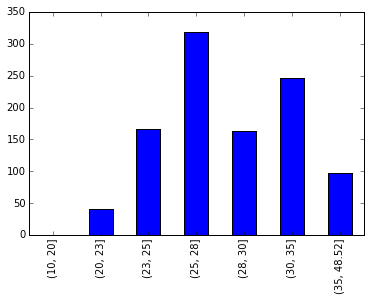

In [190]:
# 그래프로 보기
counts.reindex(filtered.cat.categories).plot(kind='bar')

In [191]:
bp_data[bp_data['status']=='normal']['Name'].head()

0       Adam_Donachie
4         Chris_Gomez
10    Jeff_Fiorentino
11      Freddie_Bynum
12      Nick_Markakis
Name: Name, dtype: object

In [192]:
# normal한 체격의 30세 이하, 포수를 뽑아서 러브콜을 보내봅시다!
bp_data[(bp_data['status']=='normal') & \
        (bp_data['Age'] < 30) & (bp_data['Position'] == 'Catcher')]

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
0,Adam_Donachie,BAL,Catcher,74,180,22.99,23.110376,normal,agegroup_4,81.64656,187.96
69,Jeff_Mathis,ANA,Catcher,72,180,23.92,24.412118,normal,agegroup_4,81.64656,182.88
105,George_Kottaras,BOS,Catcher,72,180,23.79,24.412118,normal,agegroup_4,81.64656,182.88
139,Victor_Martinez,CLE,Catcher,74,190,28.19,24.394286,normal,agegroup_3,86.18248,187.96
316,Shawn_Riggans,TB,Catcher,74,190,26.60,24.394286,normal,agegroup_3,86.18248,187.96
385,Chris_Stewart,TEX,Catcher,76,205,25.03,24.953107,normal,agegroup_3,92.98636,193.04
795,Carlos_Ruiz,PHI,Catcher,72,170,28.10,23.055889,normal,agegroup_3,77.11064,182.88
898,Jesus_Flores,WAS,Catcher,73,180,22.34,23.747874,normal,agegroup_4,81.64656,185.42


In [193]:
# bmi 25 미만인 Starting_Pitcher나 Relief_Pitcher 상관없이 모든 Pitcher들을 데려와봅시다.
bp_data[(bp_data['Position'].str.contains('Pitcher'))&(bp_data['bmi']<25)].head()

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
17,Erik_Bedard,BAL,Starting_Pitcher,73,189,27.99,24.935268,normal,agegroup_3,85.728888,185.42
18,Hayden_Penn,BAL,Starting_Pitcher,75,185,22.38,23.123158,normal,agegroup_4,83.914520,190.50
21,Steve_Trachsel,BAL,Starting_Pitcher,76,205,36.33,24.953107,normal,agegroup_1,92.986360,193.04
23,Kris_Benson,BAL,Starting_Pitcher,76,195,32.31,23.735882,normal,agegroup_2,88.450440,193.04
24,Scott_Williamson,BAL,Relief_Pitcher,72,180,31.03,24.412118,normal,agegroup_2,81.646560,182.88


In [194]:
# 종합 정보 보기. 25%, 50%, 75%는 사분위수(Quartiles)입니다.
bp_data.describe()

,Height(inches),Weight(pounds),Age,bmi,Weight(kg),Height(cm)
count,1034.000000,1033.000000,1034.000000,1033.000000,1033.000000,1034.000000
mean,73.697292,201.689255,28.736712,26.093497,91.484632,187.191122
std,2.305818,20.991491,4.320310,2.300437,9.521572,5.856779
min,67.000000,150.000000,20.900000,19.498447,68.038800,170.180000
25%,72.000000,187.000000,25.440000,24.407276,84.821704,182.880000
50%,74.000000,200.000000,27.925000,26.087904,90.718400,187.960000
75%,75.000000,215.000000,31.232500,27.604061,97.522280,190.500000
max,83.000000,290.000000,48.520000,35.261949,131.541680,210.820000


In [195]:
# 테이블 정보입니다.
bp_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1034 entries, 0 to 1033
Data columns (total 11 columns):
Name              1034 non-null object
Team              1034 non-null object
Position          1034 non-null object
Height(inches)    1034 non-null int64
Weight(pounds)    1033 non-null float64
Age               1034 non-null float64
bmi               1033 non-null float64
status            1034 non-null object
age_status        1034 non-null object
Weight(kg)        1033 non-null float64
Height(cm)        1034 non-null float64
dtypes: float64(5), int64(1), object(5)
memory usage: 96.9+ KB


In [196]:
# 빈 row 개수 찾기
bp_data['bmi'].isnull().sum()

1

In [197]:
# 1034, 1033? 빈 row 찾기.
bp_data.isnull().sum()

Name              0
Team              0
Position          0
Height(inches)    0
Weight(pounds)    1
Age               0
bmi               1
status            0
age_status        0
Weight(kg)        1
Height(cm)        0
dtype: int64

In [198]:
# null인 선수 찾기
bp_data[bp_data['bmi'].isnull()]

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
640,Kirk_Saarloos,CIN,Starting_Pitcher,72,NaN,27.77,NaN,low weight,agegroup_3,NaN,182.88


In [199]:
# 바로 적용하기
# bp_data.drop(640, inplace=True)
bp_data_not_null = bp_data.drop(640)

In [200]:
# 640번 row가 drop 되었습니다.
bp_data_not_null.describe()

,Height(inches),Weight(pounds),Age,bmi,Weight(kg),Height(cm)
count,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000,1033.000000
mean,73.698935,201.689255,28.737648,26.093497,91.484632,187.195295
std,2.306330,20.991491,4.322298,2.300437,9.521572,5.858077
min,67.000000,150.000000,20.900000,19.498447,68.038800,170.180000
25%,72.000000,187.000000,25.440000,24.407276,84.821704,182.880000
50%,74.000000,200.000000,27.930000,26.087904,90.718400,187.960000
75%,75.000000,215.000000,31.240000,27.604061,97.522280,190.500000
max,83.000000,290.000000,48.520000,35.261949,131.541680,210.820000


In [201]:
# index 640 자리가 비었습니다.
bp_data_not_null[635:645]

,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
635,Ryan_Freel,CIN,Outfielder,70,180,30.98,25.827025,over weight,agegroup_2,81.646560,177.80
636,Kyle_Lohse,CIN,Starting_Pitcher,74,201,28.41,25.806587,over weight,agegroup_3,91.171992,187.96
637,Bronson_Arroyo,CIN,Starting_Pitcher,77,190,30.01,22.530462,normal,agegroup_2,86.182480,195.58
638,Eric_Milton,CIN,Starting_Pitcher,75,208,31.57,25.997929,over weight,agegroup_2,94.347136,190.50
639,Aaron_Harang,CIN,Starting_Pitcher,79,240,28.81,27.036783,over weight,agegroup_3,108.862080,200.66
641,Elizardo_Ramirez,CIN,Starting_Pitcher,72,180,24.09,24.412118,normal,agegroup_4,81.646560,182.88
642,Todd_Coffey,CIN,Relief_Pitcher,77,230,26.47,27.273718,over weight,agegroup_3,104.326160,195.58
643,Brian_Shackelford,CIN,Relief_Pitcher,73,195,30.50,25.726864,over weight,agegroup_2,88.450440,185.42
644,Bill_Bray,CIN,Relief_Pitcher,75,215,23.74,26.872860,over weight,agegroup_4,97.522280,190.50
645,Bobby_Livingston,CIN,Relief_Pitcher,75,190,24.49,23.748109,normal,agegroup_4,86.182480,190.50


In [202]:
# 처음부터 다시 index를 겁니다.
bp_data_not_null.reset_index(inplace=True)

In [203]:
# 640이 생겼습니다.
bp_data_not_null[635:645]

,index,Name,Team,Position,Height(inches),Weight(pounds),Age,bmi,status,age_status,Weight(kg),Height(cm)
635,635,Ryan_Freel,CIN,Outfielder,70,180,30.98,25.827025,over weight,agegroup_2,81.646560,177.80
636,636,Kyle_Lohse,CIN,Starting_Pitcher,74,201,28.41,25.806587,over weight,agegroup_3,91.171992,187.96
637,637,Bronson_Arroyo,CIN,Starting_Pitcher,77,190,30.01,22.530462,normal,agegroup_2,86.182480,195.58
638,638,Eric_Milton,CIN,Starting_Pitcher,75,208,31.57,25.997929,over weight,agegroup_2,94.347136,190.50
639,639,Aaron_Harang,CIN,Starting_Pitcher,79,240,28.81,27.036783,over weight,agegroup_3,108.862080,200.66
640,641,Elizardo_Ramirez,CIN,Starting_Pitcher,72,180,24.09,24.412118,normal,agegroup_4,81.646560,182.88
641,642,Todd_Coffey,CIN,Relief_Pitcher,77,230,26.47,27.273718,over weight,agegroup_3,104.326160,195.58
642,643,Brian_Shackelford,CIN,Relief_Pitcher,73,195,30.50,25.726864,over weight,agegroup_2,88.450440,185.42
643,644,Bill_Bray,CIN,Relief_Pitcher,75,215,23.74,26.872860,over weight,agegroup_4,97.522280,190.50
644,645,Bobby_Livingston,CIN,Relief_Pitcher,75,190,24.49,23.748109,normal,agegroup_4,86.182480,190.50


In [204]:
# 크롤링으로 긁어온 영화 데이터로 위에서 배운 것들을 복습해봅시다.
# csv format으로 저장하기 (encoding utf-8)
movie_df = pd.read_csv('./movie_from_df.csv')
movie_df.head()

,title,scorr,genre,running time,actors
0,The Woman in Black 2: Angel of Death (2014),42,Drama/Horror/Thriller,98 min,Helen McCrory/Jeremy Irvine/Phoebe Fox/Leanne ...
1,A Most Violent Year (2014),79,Action/Crime/Drama/Thriller,125 min,Oscar Isaac/Jessica Chastain/David Oyelowo/Ale...
2,Leviafan (2014),92,Drama,140 min,Aleksey Serebryakov/Elena Lyadova/Roman Madyan...
3,[REC] 4: Apocalipsis (2014),53,Action/Horror/Thriller,95 min,Manuela Velasco/Paco Manzanedo/Héctor Colomé/I...
4,The Search for General Tso (2014),72,Documentary/Comedy/History/Mystery,71 min,Ian Cheney


In [205]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 389 entries, 0 to 388
Data columns (total 5 columns):
title           389 non-null object
scorr           373 non-null float64
genre           389 non-null object
running time    389 non-null object
actors          389 non-null object
dtypes: float64(1), object(4)
memory usage: 18.2+ KB


In [206]:
movie_df.describe()

,scorr
count,373.000000
mean,58.104558
std,17.687013
min,11.000000
25%,46.000000
50%,58.000000
75%,72.000000
max,95.000000


## 마지막 해보기

크롤링 못하신 분들은 링크[https://www.dropbox.com/s/xymrqvo34qbd2mr/movie_from_df.csv?dl=1](https://www.dropbox.com/s/xymrqvo34qbd2mr/movie_from_df.csv?dl=1)에서 다운 받아서 사용해주세요.


크롤링으로 긁어온 데이터들을 가지고, 아래의 일들을 해봅시다.

1. score를 0~50, 50~70, 70~90, 90~100 range로 나누고, comment 컬럼에 bad, so so, good, fantastic을 넣어봅시다. 
2. 그래프로 그려봅시다.
3. drama 장르인 영화들을 뽑아봅시다.
4. Comedy이면서 러닝타임이 120분 이상인 것들을 골라봅시다.
5. 러닝 타임이 120분 이상인 평가가 good인 Comedy를 골라봅시다.

In [208]:
import pandas as pd
movie_df = pd.read_csv('./movie_from_df.csv')
movie_df.head()

,title,scorr,genre,running time,actors
0,The Woman in Black 2: Angel of Death (2014),42,Drama/Horror/Thriller,98 min,Helen McCrory/Jeremy Irvine/Phoebe Fox/Leanne ...
1,A Most Violent Year (2014),79,Action/Crime/Drama/Thriller,125 min,Oscar Isaac/Jessica Chastain/David Oyelowo/Ale...
2,Leviafan (2014),92,Drama,140 min,Aleksey Serebryakov/Elena Lyadova/Roman Madyan...
3,[REC] 4: Apocalipsis (2014),53,Action/Horror/Thriller,95 min,Manuela Velasco/Paco Manzanedo/Héctor Colomé/I...
4,The Search for General Tso (2014),72,Documentary/Comedy/History/Mystery,71 min,Ian Cheney


### 참고
- [Numpy data type에 대하여](http://docs.scipy.org/doc/numpy-1.10.1/user/basics.types.html)
- [Pandas DataFrame에 대하여](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.html)
- [DataFrame에서 String은 왜 dtype이 object인가요](http://stackoverflow.com/questions/21018654/strings-in-a-dataframe-but-dtype-is-object)
- [Python and 와 &는 무엇이 다른가요](http://stackoverflow.com/questions/22646463/difference-between-and-boolean-vs-bitwise-in-python-why-difference-i)
- [백분위수, 사분위수란?](https://docs.tibco.com/pub/spotfire_web_player/6.0.0-november-2013/ko-KR/WebHelp/GUID-10AD38BA-A888-4CEB-B716-44E2E02C8B03.html)
- [DataFrame row 추가하는 법](http://stackoverflow.com/questions/19365513/how-to-add-an-extra-row-to-a-pandas-dataframe)
- [Series apply 함수](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.apply.html)
- [Series plot 함수](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.plot.html)